In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
# color = sns.color_palette()

# from sklearn.cluster import KMeans

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# DATA_DIR = '../Zillow/data' 
# df_properties = pd.read_csv(DATA_DIR+'/properties_2016.csv')

df_properties = pd.read_csv('properties_2016.csv')
df_train      = pd.read_csv('train_2016_v2.csv')

df_train['logerror'] = df_train['logerror'].replace('NaN', df_train['logerror'].mean())

# df_train = pd.read_csv(DATA_DIR+'/train_2016_v2.csv', parse_dates=["transactiondate"])

### ID + fire + pool Features
* **'airconditioningtypeid'**	 Type of cooling system present in the home (if any)
* **'architecturalstyletypeid'**	 Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
* **'buildingclasstypeid'**	 The building framing type (steel frame, wood frame, concrete/brick) 
* **'buildingqualitytypeid'**	Overall assessment of condition of the building from best (lowest) to worst (highest)
* **'decktypeid'**	Type of deck (if any) present on parcel
* **'heatingorsystemtypeid'**	 Type of home heating system
* **'pooltypeid10'**	 Spa or Hot Tub
* **'pooltypeid2'**	 Pool with Spa/Hot Tub
* **'pooltypeid7'**	 Pool without hot tub
* **'poolcnt'**	  Number of pools on the lot (if any)
* **'poolcnt'**	  Total square footage of all pools on property
* **'storytypeid'**	 Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.).
* **'typeconstructiontypeid'**	 What type of construction material was used to construct the home
* **'fireplaceflag'**	 Is a fireplace present in this home 
* **'fireplacecnt'**	  Number of fireplaces in a home (if any)

In [3]:
phyidcolumns = ['parcelid',
                'airconditioningtypeid', 
                'architecturalstyletypeid', 
                'buildingclasstypeid', 
                'buildingqualitytypeid',  
                'decktypeid', 
                'heatingorsystemtypeid',
                'pooltypeid10',
                'pooltypeid2', 
                'pooltypeid7',
                'poolcnt',
                'poolsizesum',
                'storytypeid',
                'typeconstructiontypeid',
                'fireplaceflag',
                'fireplacecnt']

phyid = df_properties[phyidcolumns]

In [4]:
phyid.isnull().sum()

parcelid                          0
airconditioningtypeid        762237
architecturalstyletypeid    1046521
buildingclasstypeid         1044110
buildingqualitytypeid        363656
decktypeid                  1042564
heatingorsystemtypeid        410533
pooltypeid10                1035606
pooltypeid2                 1037303
pooltypeid7                  877236
poolcnt                      865964
poolsizesum                 1038636
storytypeid                 1048016
typeconstructiontypeid      1046268
fireplaceflag               1046752
fireplacecnt                 938500
dtype: int64

In [5]:
index = phyid[phyid['pooltypeid2'].isnull()][phyid['poolcnt'].notnull()][phyid['pooltypeid7'].isnull()].index
phyid.loc[index,'pooltypeid2'] = 1

index = phyid[phyid['pooltypeid7'].isnull()][phyid['poolcnt'].notnull()][phyid['pooltypeid2'].isnull()].index
phyid.loc[index,'pooltypeid7'] = 1

index = phyid[phyid['poolcnt'].isnull()][phyid['poolsizesum'].isnull()].index
phyid.loc[index,'poolsizesum'] = 0

phyid['pooltypeid10'] = phyid['pooltypeid10'].fillna(0)
phyid['pooltypeid2']  = phyid['pooltypeid2'].fillna(0)
phyid['pooltypeid7']  = phyid['pooltypeid7'].fillna(0)

phyid['poolcnt'] = phyid['poolcnt'].fillna(0)

phyid['poolsizesum_new']                                = 'medium'
phyid['poolsizesum_new'][phyid['poolsizesum']<=430]     = 'small'
phyid['poolsizesum_new'][phyid['poolsizesum']==0]       = 'none'
phyid['poolsizesum_new'][phyid['poolsizesum']>=594]     = 'big'
phyid['poolsizesum_new'][phyid['poolsizesum'].isnull()] = 'unknown'
phyid['poolsizesum_new'][phyid['pooltypeid2']>0]        = 'unknownid2'

phyid['poolsizesum'] = phyid['poolsizesum'].fillna(phyid['poolsizesum'][phyid['poolcnt']>0].median())

In [6]:
phyid['fireplaceflag'][phyid['fireplacecnt'].notnull()] = 'True'

index = phyid[phyid['fireplaceflag'].notnull()][phyid['fireplacecnt'].isnull()].index
phyid.loc[index,'fireplacecnt'] = 1

phyid['fireplaceflag'] = phyid['fireplaceflag'].fillna('False')
phyid['fireplacecnt']  = phyid['fireplacecnt'].fillna(0)

In [7]:
phyid['airconditioningtypeid'].value_counts()

1.0     262065
13.0     20531
5.0       3059
11.0       651
12.0        24
9.0          6
3.0          2
Name: airconditioningtypeid, dtype: int64

# 修改

In [8]:
# 你之前说用众数（如果我没记错的话）来填'airconditioningtypeid'，那么应该是'1'而不是'5'.
phyid['airconditioningtypeid'] = phyid['airconditioningtypeid'].fillna(0)
phyid['airconditioningtypeid'] = phyid['airconditioningtypeid'].map(lambda x: int(x)).astype(str)

In [9]:
phyid['architecturalstyletypeid'] = phyid['architecturalstyletypeid'].fillna(0)# 0:unknown
phyid['architecturalstyletypeid'] = phyid['architecturalstyletypeid'].map(lambda x: int(x)).astype(str)

In [10]:
index = phyid[phyid['heatingorsystemtypeid'].isnull()][phyid['pooltypeid2']>0].index
phyid.loc[index,'heatingorsystemtypeid'] = 6

index = phyid[phyid['heatingorsystemtypeid'].isnull()].index
phyid.loc[index,'heatingorsystemtypeid'] = 2

In [11]:
phyid['typeconstructiontypeid'] = phyid['typeconstructiontypeid'].fillna(0)# 0:unknown
phyid['storytypeid']            = phyid['storytypeid'].fillna(0)# 0:unknown
phyid['buildingclasstypeid']    = phyid['buildingclasstypeid'].fillna(0)# 0:unknown
phyid['decktypeid']             = phyid['decktypeid'].fillna(0)

# 转成string之前看一下correlation

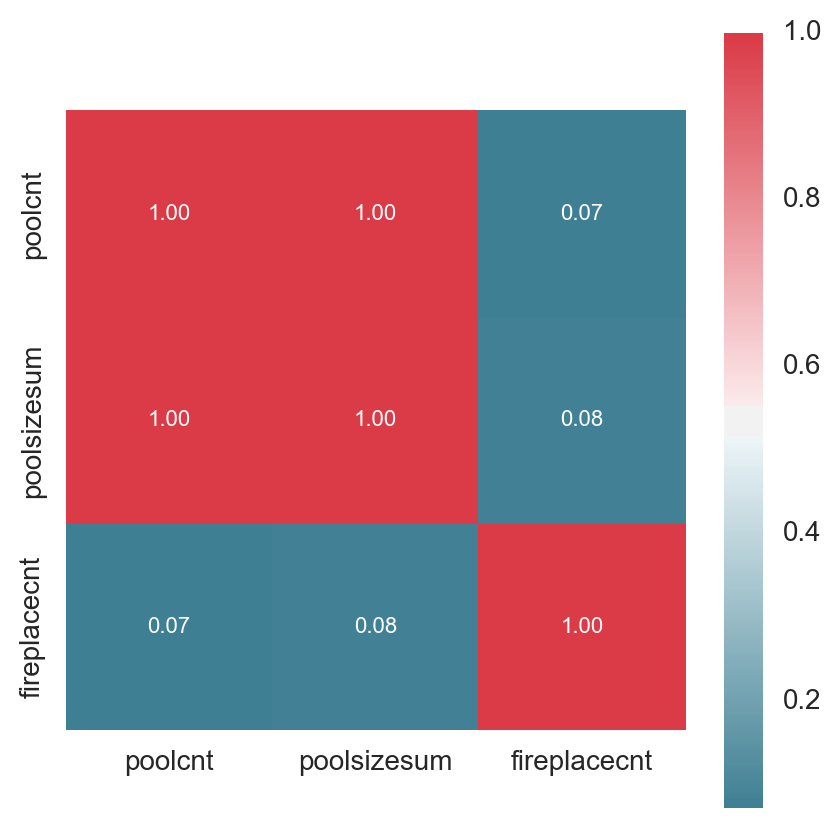

In [13]:
plt.figure(figsize = (5,5))

corr_mat = phyid[['poolcnt',
                  'poolsizesum',
                  'fireplacecnt']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, cbar=True, annot=True, square=True, cmap=cmap, fmt='.2f', annot_kws={'size': 8})

In [14]:
for i in ['pooltypeid10',
          'pooltypeid2',
          'pooltypeid7',
          'airconditioningtypeid',
          'architecturalstyletypeid',
          'typeconstructiontypeid',
          'storytypeid',
          'buildingclasstypeid',
          'decktypeid',
          'heatingorsystemtypeid']:
    phyid[i] = phyid[i].map(lambda x: int(x)).astype(str)

In [15]:
phyid.dtypes

parcelid                      int64
airconditioningtypeid        object
architecturalstyletypeid     object
buildingclasstypeid          object
buildingqualitytypeid       float64
decktypeid                   object
heatingorsystemtypeid        object
pooltypeid10                 object
pooltypeid2                  object
pooltypeid7                  object
poolcnt                     float64
poolsizesum                 float64
storytypeid                  object
typeconstructiontypeid       object
fireplaceflag                object
fireplacecnt                float64
poolsizesum_new              object
dtype: object

In [16]:
# phyid.to_csv("df_properties_phy.csv", index = False)

In [17]:
phyid.isnull().sum()

parcelid                         0
airconditioningtypeid            0
architecturalstyletypeid         0
buildingclasstypeid              0
buildingqualitytypeid       363656
decktypeid                       0
heatingorsystemtypeid            0
pooltypeid10                     0
pooltypeid2                      0
pooltypeid7                      0
poolcnt                          0
poolsizesum                      0
storytypeid                      0
typeconstructiontypeid           0
fireplaceflag                    0
fireplacecnt                     0
poolsizesum_new                  0
dtype: int64

In [18]:
phycolumns = ['parcelid',                           # done
              'airconditioningtypeid',              # done
              'architecturalstyletypeid',           # done
              'basementsqft',  
              'bathroomcnt', 
              'bedroomcnt',
              'buildingclasstypeid',                # done
              'buildingqualitytypeid', 
              'calculatedbathnbr', 
              'decktypeid',                         # done
              'finishedfloor1squarefeet',
              'calculatedfinishedsquarefeet', 
              'finishedsquarefeet12', 
              'finishedsquarefeet13', 
              'finishedsquarefeet15',
              'finishedsquarefeet50', 
              'finishedsquarefeet6', 
              'fireplacecnt',                       # done
              'fullbathcnt', 
              'garagecarcnt', 
              'garagetotalsqft',
              'hashottuborspa',
              'heatingorsystemtypeid',              # done
              'lotsizesquarefeet',
              'poolcnt',                            # done
              'poolsizesum',                        # done
              'pooltypeid10',                       # done
              'pooltypeid2',                        # done
              'pooltypeid7',                        # done
              'rawcensustractandblock',
              'roomcnt',
              'storytypeid',                        # done
              'threequarterbathnbr',
              'typeconstructiontypeid',             # done
              'unitcnt',
              'yardbuildingsqft17', 
              'yardbuildingsqft26', 
              'yearbuilt', 
              'numberofstories', 
              'fireplaceflag']                      # done
phyprop = df_properties[phycolumns]

In [19]:
try_phyid = pd.concat([phyid[:90276],
                       df_train['logerror']], axis=1)

# 补充

In [20]:
# 使用median填补'poolsizesum'造成和'poolcnt'之间超高的correlation，不过倒是很符合逻辑
phyid[['poolsizesum', 'poolcnt']].corr()

,poolsizesum,poolcnt
poolsizesum,1.000000,0.996606
poolcnt,0.996606,1.000000


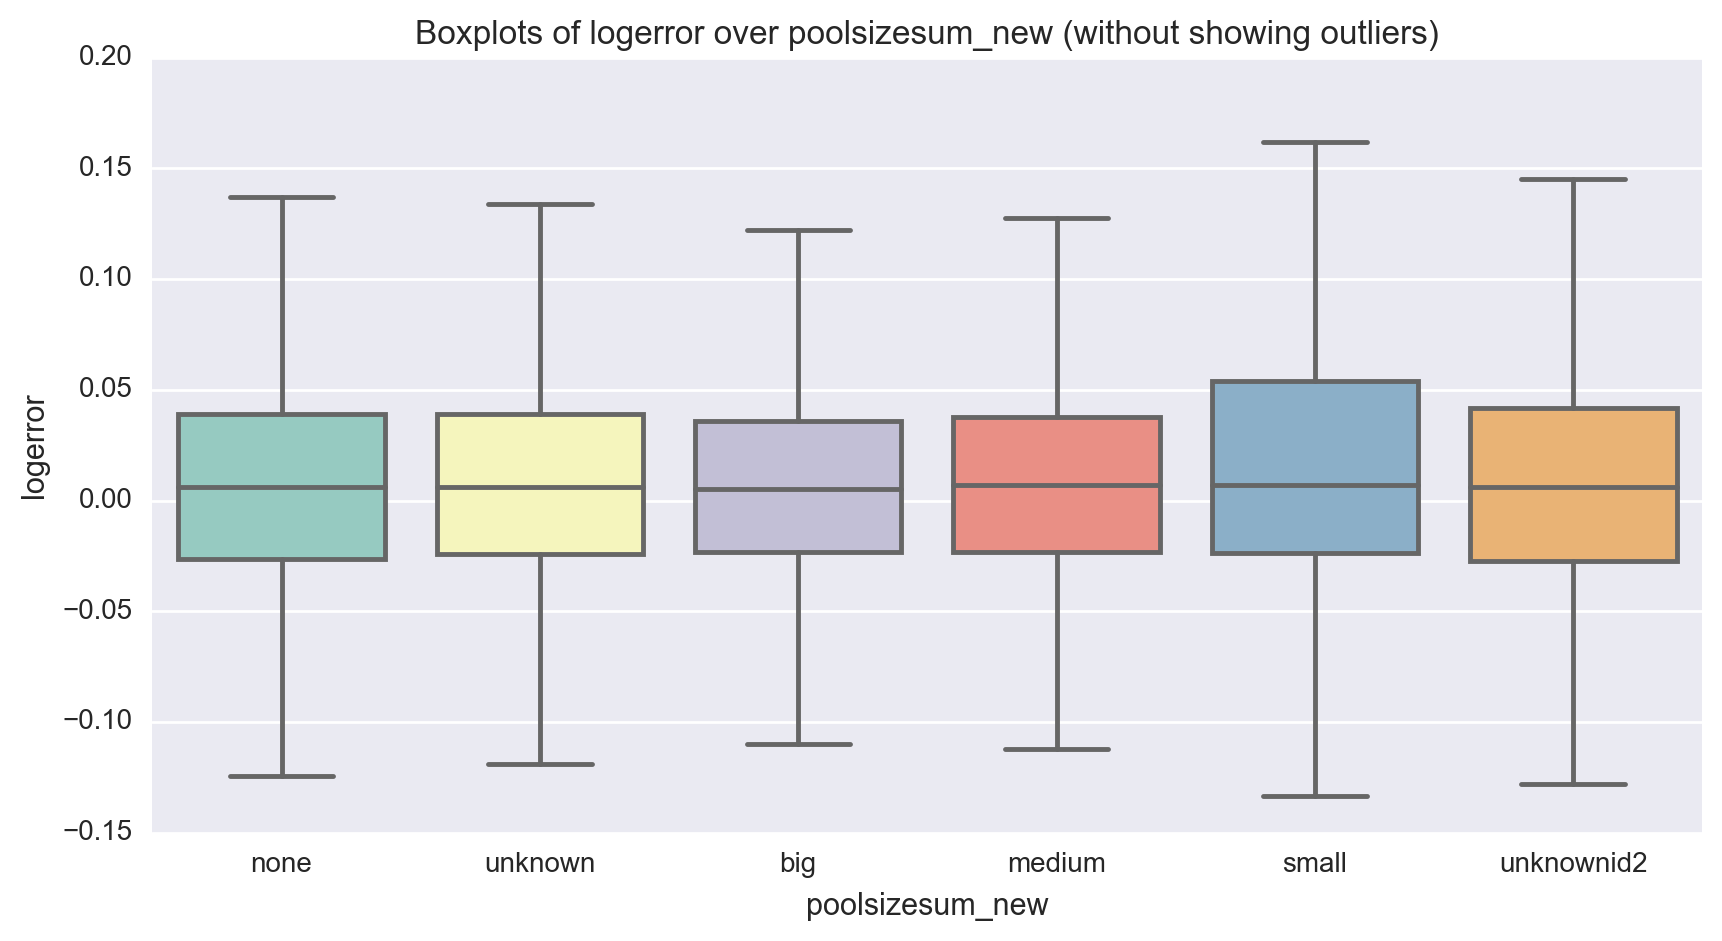

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(x="poolsizesum_new", y="logerror", 
            data=try_phyid, palette='Set3', showfliers=False)
plt.title('Boxplots of logerror over poolsizesum_new (without showing outliers)')

# 当'fireplacecnt'为5时相对应的logerror有left skewed现象，估计是在train上的数量太少造成

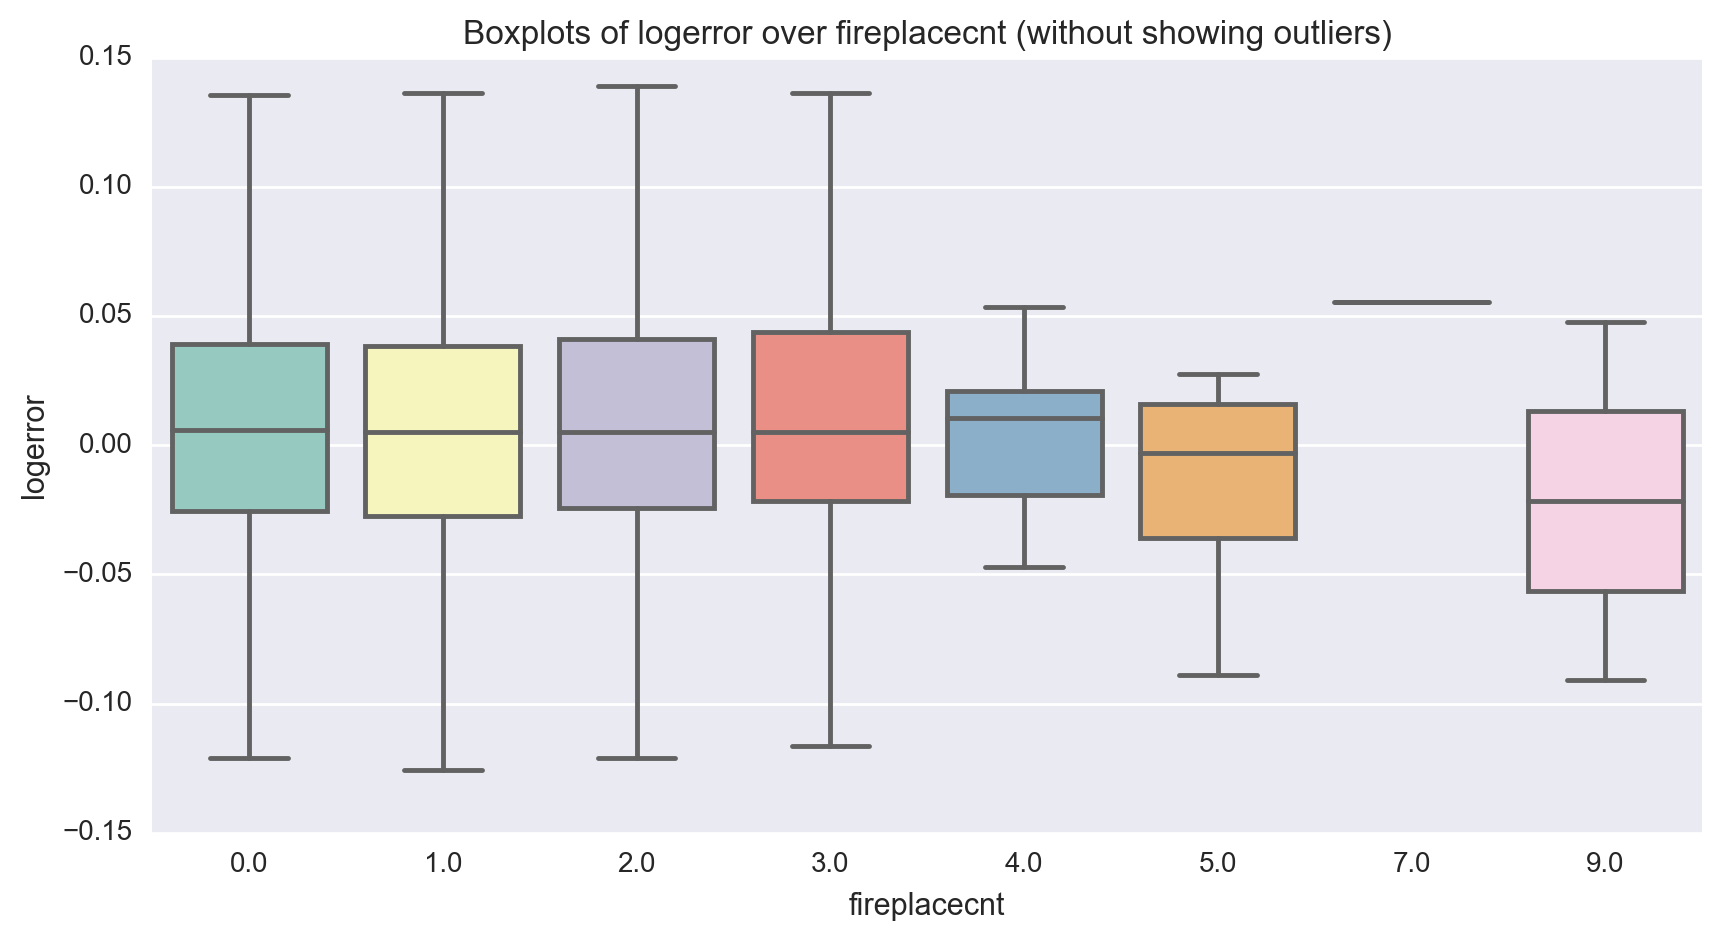

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(x="fireplacecnt", y="logerror", 
            data=try_phyid, palette='Set3', showfliers=False)
plt.title('Boxplots of logerror over fireplacecnt (without showing outliers)')

# 第9类'airconditioningtypeid'相对应的logerror整体沿x轴右移，仍然近似正态分布

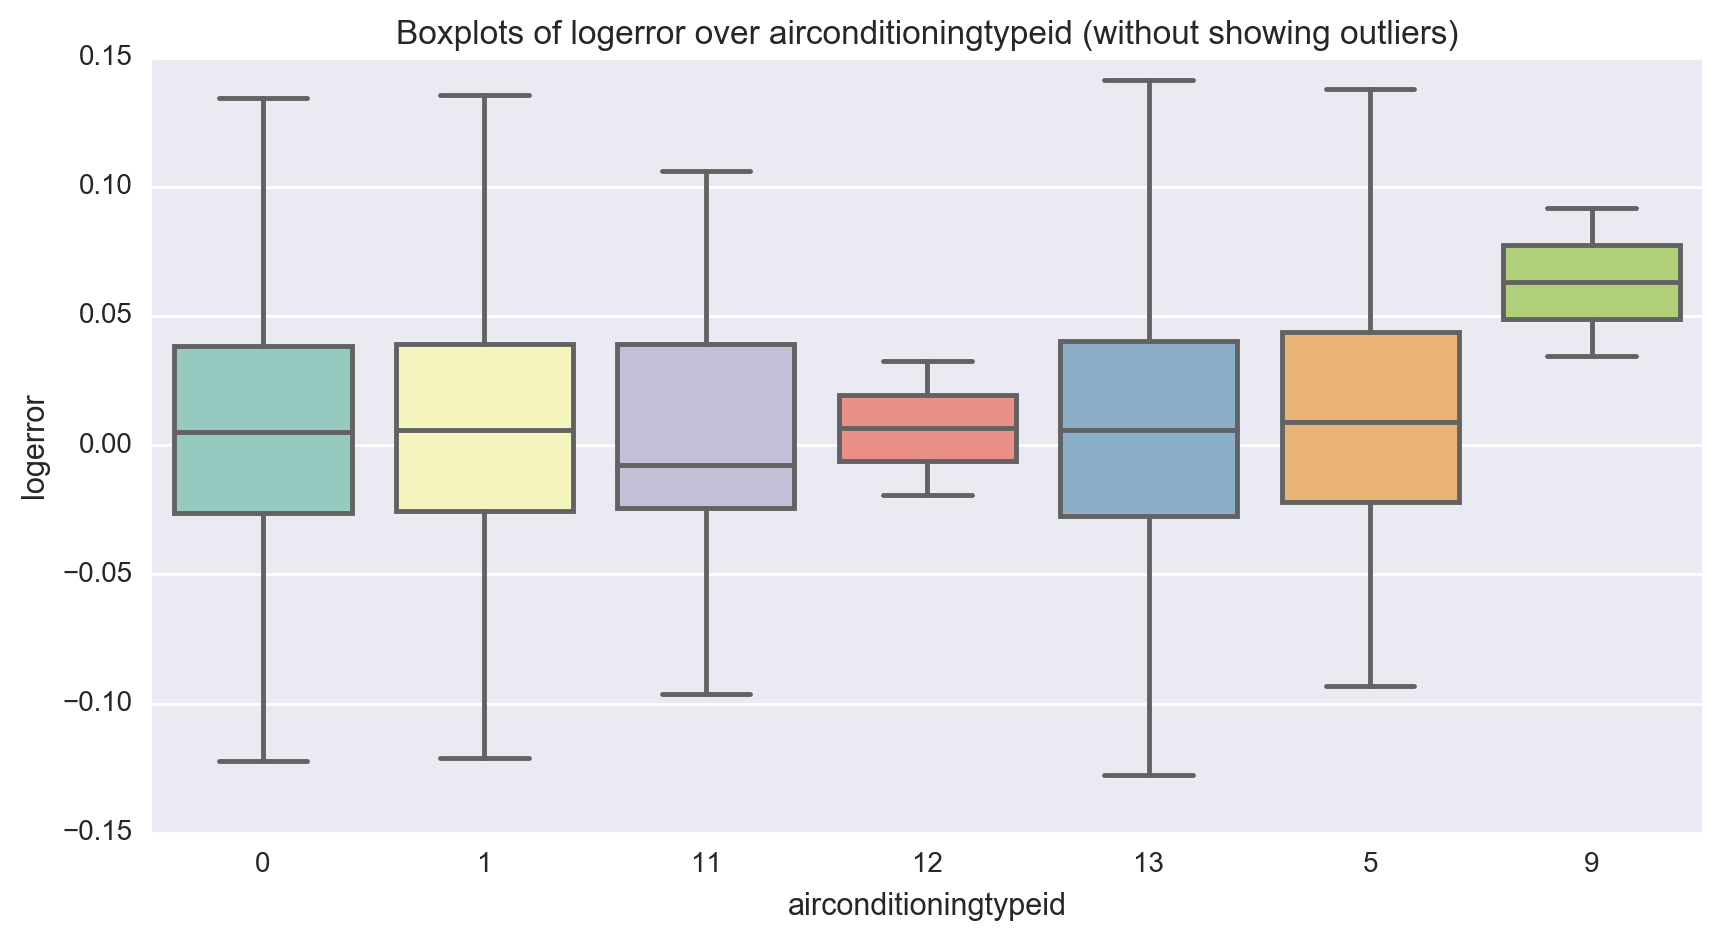

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(x="airconditioningtypeid", y="logerror", 
            data=try_phyid, palette='Set3', showfliers=False)
plt.title('Boxplots of logerror over airconditioningtypeid (without showing outliers)')

# 第2类和第8类'architecturalstyletypeid'相对应的logerror有显著的left skewed现象，不过因为是在train上的分布所以可能是个例。总体来说大部分的feature在各自的取值范围／category下相对应的logerror近似呈正态分布

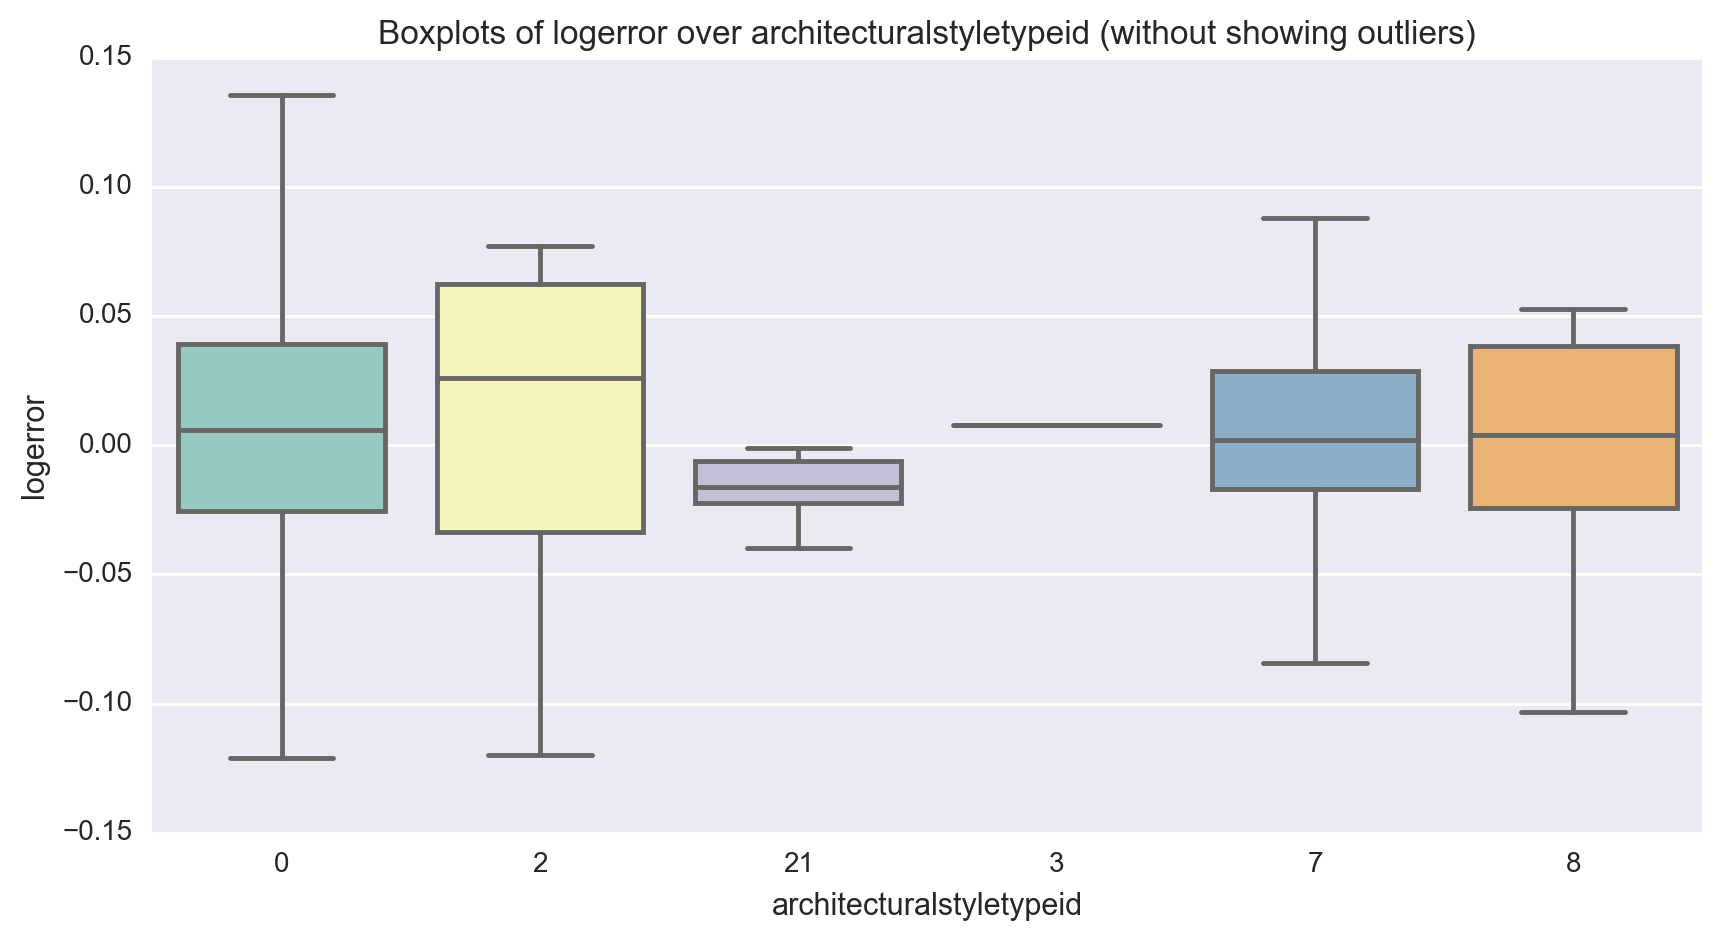

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(x="architecturalstyletypeid", y="logerror", 
            data=try_phyid, palette='Set3', showfliers=False)
plt.title('Boxplots of logerror over architecturalstyletypeid (without showing outliers)')